In [1]:
## Twint
import twint
import nest_asyncio
from getpass import getpass
from time import sleep
from selenium.webdriver.common.keys import Keys
# from selenium.common.exceptions import NoSuchElementException
from selenium import webdriver
import json
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

nest_asyncio.apply()

In [2]:
ResourcePath = "Resource/"

In [3]:
def getTwint(username, keyword, since, until, filename, mode):
    f = open(ResourcePath + filename, mode)
    f.write('')
    f.close()

    c = twint.Config()
    c.Username = username
    c.Search = keyword
    c.Since = since
    c.Until = until
    c.Count = True         
    c.Retweets = True
    c.Stats = True 
    c.Show_hashtags = True
    c.Hide_output = True
    c.Store_json = True
    c.Output = ResourcePath + filename

    twint.run.Search(c)
    sleep(5)

In [ ]:
# getTwint('PRFMnews', 'vaksin OR vaksinasi OR astrazeneca OR sinovac', "2020-08-01", "2021-01-31", 'before.json', 'w')
# getTwint('PRFMnews', 'vaksin OR vaksinasi OR astrazeneca OR sinovac', "2021-02-15", "2021-04-15", 'after.json', 'w')

In [ ]:
## Selenium
chrome_options = webdriver.ChromeOptions()
prefs = {"profile.default_content_setting_values.notifications" : 2}
chrome_options.add_experimental_option("prefs",prefs)
# chrome_options.add_argument('headless') # untuk menutup browser

#specify the path to chromedriver.exe
driver = webdriver.Chrome('D:\Kuliah\chromedriver.exe',chrome_options=chrome_options)

In [ ]:
driver.get('https://www.twitter.com/login')
sleep(2)

username = driver.find_element_by_xpath('//input[@name="session[username_or_email]"]')
username.send_keys('082245247958')

my_password = getpass()

password = driver.find_element_by_xpath('//input[@name="session[password]"]')
password.send_keys(my_password)
password.send_keys(Keys.RETURN)

In [4]:
def get_list_likes(link):
    list_likes = set()
    driver.get(link + '/likes')#open link
    sleep(5) #jeda waktu
    
    #scroll to bottom
    SCROLL_PAUSE_TIME = 0.5
    driver.execute_script("a = document.getElementsByClassName('r-1pp923h');")
    last_height = driver.execute_script("return a[0].scrollHeight")
    while True:
        try:
            likes_container = driver.find_element_by_xpath('//div[@aria-label="Timeline: Liked by"]') #element dasar likes
            if likes_container: #jika ada maka
                likes = likes_container.find_elements_by_xpath('.//div[@dir="ltr"]/span')
                for like in likes:
                    list_likes.add(like.text[1:]) # Delete @
        except:
            pass
        driver.execute_script("a[0].scrollTop = " + str(last_height))
        # Wait to load page
        sleep(SCROLL_PAUSE_TIME)
        # Calculate new scroll height and compare with last scroll height
        new_height = driver.execute_script("return a[0].scrollHeight")
        if new_height == last_height:
            break
        last_height = new_height

    return list(list_likes)

In [5]:
def get_list_retweets(link):
    list_retweets = set()
    driver.get(link + '/retweets')#open link
    sleep(5) #jeda waktu
    
    #scroll to bottom
    SCROLL_PAUSE_TIME = 0.5
    driver.execute_script("a = document.getElementsByClassName('r-1pp923h');")
    last_height = driver.execute_script("return a[0].scrollHeight")
    while True:
        try:
            retweets_container = driver.find_element_by_xpath('//div[@aria-label="Timeline: Retweeted by"]')
            if retweets_container: #jika ada maka
                retweets = retweets_container.find_elements_by_xpath('.//div[@dir="ltr"]/span')
                for retweet in retweets:
                    list_retweets.add(retweet.text[1:]) # Delete @
        except:
            pass
        driver.execute_script("a[0].scrollTop = " + str(last_height))
        # Wait to load page
        sleep(SCROLL_PAUSE_TIME)
        # Calculate new scroll height and compare with last scroll height
        new_height = driver.execute_script("return a[0].scrollHeight")
        if new_height == last_height:
            break
        last_height = new_height

    return list(list_retweets)

In [6]:
# Iterasi semua tweet terkait untuk dicari likes dan retweets
def getInteraction(dfTweets, filename, user_done):
    tweet_ids = dfTweets['id'].values.tolist()
    tweet_usernames = dfTweets['username'].values.tolist()
    interactionList = []
    for i in range(len(tweet_ids)):
        if tweet_usernames[i] in user_done:
            continue

        while True:
            try:
                tweet_id = tweet_ids[i]
                tweet_username = tweet_usernames[i]
                uri = 'https://twitter.com/'+ tweet_username + '/status/'
                interaction = {
                    'tweet_id' : tweet_id,
                    'username' : tweet_username,
                    'likes' : get_list_likes(uri + str(tweet_id)),
                    'retweet' : get_list_retweets(uri + str(tweet_id))
                }
            except:
                sleep(5)
                continue
            break

        interactionList.append(interaction)
        interactionJSON = json.dumps(interactionList)
        with open(ResourcePath + filename, 'w+') as f:
            f.write(interactionJSON)


In [7]:
def getConvertToList(filename):
    with open(ResourcePath + filename, 'r') as f:
        interactionJSON = f.read()
        interactions = json.loads(interactionJSON)

    likes_dict = dict()
    retweets_dict = dict()
    for interaction in interactions:
        for account in interaction['likes']:
            likes_dict[account] = likes_dict.get(account,0) + 1
        for account in interaction['retweet']:
            retweets_dict[account] = retweets_dict.get(account, 0) + 1

    likes_dict = dict(sorted(likes_dict.items(), key=lambda item: item[1], reverse=True))
    retweets_dict = dict(sorted(retweets_dict.items(), key=lambda item: item[1], reverse=True))

    return likes_dict, retweets_dict


In [8]:
def getUserPotent(filename, user_done):
    likes_dict, retweets_dict = getConvertToList(filename)
    likes_potent = []
    retweets_potent = []
    for username, count in likes_dict.items():
        if username.lower() in user_done:
            continue
        if count >= 2:
            likes_potent.append(username.lower())

    for username, count in retweets_dict.items():
        if username.lower() in user_done:
            continue
        if count >= 2:
            retweets_potent.append(username.lower())

    user_potent = likes_potent + list(set(retweets_potent) - set(likes_potent))
    return user_potent

In [9]:
user_done_bf = set()
user_done_af = set()

In [10]:
dfBefore = pd.read_json( ResourcePath + 'before.json' , lines = True)
dfAfter = pd.read_json( ResourcePath + 'after.json' , lines = True)
dfAll = dfBefore.append(dfAfter)

# getInteraction(dfBefore, 'beforeInteraction.json')
# getInteraction(dfAfter, 'afterInteraction.json')

user_done_bf.update(set(dfBefore['username'].values.tolist()))
user_done_af.update(set(dfAfter['username'].values.tolist()))

In [11]:
bf_Potent = getUserPotent('beforeInteraction.json', user_done_af)
# for i in bf_Potent:
#     getTwint(i, 'vaksin OR vaksinasi OR astrazeneca OR sinovac', "2020-08-01", "2021-01-31", 'before_d1.json', 'a')

af_Potent = getUserPotent('afterInteraction.json', user_done_af)
# for i in af_Potent:
#     getTwint(i, 'vaksin OR vaksinasi OR astrazeneca OR sinovac', "2021-02-15", "2021-04-15", 'after_d1.json', 'a')

In [12]:
dfBefore = pd.read_json( ResourcePath + 'before_d1.json' , lines = True)
dfAfter = pd.read_json( ResourcePath + 'after_d1.json' , lines = True)
dfAll = dfBefore.append(dfAfter)

# getInteraction(dfBefore, 'beforeInteraction_d1.json')
# getInteraction(dfAfter, 'afterInteraction_d1.json')

user_done_bf.update(set(dfBefore['username'].values.tolist()))
user_done_af.update(set(dfAfter['username'].values.tolist()))

In [13]:
bf_Potent = getUserPotent('beforeInteraction_d1.json', user_done_bf)
# for i in bf_Potent:
#     getTwint(i, 'vaksin OR vaksinasi OR astrazeneca OR sinovac', "2020-08-01", "2021-01-31", 'before_d2.json', 'a')

af_Potent = getUserPotent('beforeInteraction_d1.json', user_done_af)
# for i in af_Potent:
#     getTwint(i, 'vaksin OR vaksinasi OR astrazeneca OR sinovac', "2021-02-15", "2021-04-15", 'after_d2.json', 'a')

In [14]:
# Get JSON max item computed
dfBefore = pd.read_json( ResourcePath + 'before_d2.json' , lines = True)
dfAfter = pd.read_json( ResourcePath + 'after_d2.json' , lines = True)
dfAll = dfBefore.append(dfAfter)

# getInteraction(dfAfter, 'afterInteraction_d2.json', user_done_af)
# getInteraction(dfBefore, 'beforeInteraction_d2.json', user_done_bf)

user_done_bf.update(set(dfBefore['username'].values.tolist()))
user_done_af.update(set(dfAfter['username'].values.tolist()))

In [15]:
def getEdges(filename):
    with open(ResourcePath + filename, 'r') as f:
        interactionJSON = f.read()
        interactions = json.loads(interactionJSON)

    likes_dict = dict()
    retweets_dict = dict()

    for interaction in interactions:
        firstAccount = interaction['username']
        for secondAccount in interaction['likes']:
            tupleAccount = (firstAccount, secondAccount.lower())
            likes_dict[tupleAccount] = likes_dict.get(tupleAccount,0) + 1
        for secondAccount in interaction['retweet']:
            tupleAccount = (firstAccount, secondAccount.lower())
            retweets_dict[tupleAccount] = retweets_dict.get(tupleAccount,0) + 1

    return likes_dict, retweets_dict

In [16]:
bf_edgesRoot_likes, bf_edgesRoot_retweet = getEdges('beforeInteraction.json')
bf_edgesD1_likes, bf_edgesD1_retweet = getEdges('beforeInteraction_d1.json')
bf_edgesD2_likes, bf_edgesD2_retweet = getEdges('beforeInteraction_d2.json')

af_edgesRoot_likes, af_edgesRoot_retweet = getEdges('afterInteraction.json')
af_edgesD1_likes, af_edgesD1_retweet = getEdges('afterInteraction_d1.json')
af_edgesD2_likes, af_edgesD2_retweet = getEdges('afterInteraction_d2.json')

In [17]:
import itertools 
import collections

def combineDict(dict1, dict2):
    Cdict = collections.defaultdict(int)
    
    for key, val in itertools.chain(dict1.items(), dict2.items()):
        Cdict[key] += val
    return dict(Cdict)

In [18]:
bf_edgesRoot = combineDict(bf_edgesRoot_likes, bf_edgesRoot_retweet)
bf_edgesD1 = combineDict(bf_edgesD1_likes, bf_edgesD1_retweet)
bf_edgesD2 = combineDict(bf_edgesD2_likes, bf_edgesD2_retweet)
bf_edges = combineDict(bf_edgesRoot, bf_edgesD1)
bf_edges = combineDict(bf_edges, bf_edgesD2)

af_edgesRoot = combineDict(af_edgesRoot_likes, af_edgesRoot_retweet)
af_edgesD1 = combineDict(af_edgesD1_likes, af_edgesD1_retweet)
af_edgesD2 = combineDict(af_edgesD2_likes, af_edgesD2_retweet)
af_edges = combineDict(af_edgesRoot, af_edgesD1)
af_edges = combineDict(af_edges, af_edgesD2)


In [19]:
import networkx as nx
import matplotlib.pyplot as plt
import mpld3
import re
import itertools
import math

In [20]:
bf_nodes = dict()
af_nodes = dict()

for userTuple, weight in bf_edges.items():
    a, b = userTuple
    bf_nodes[a] = bf_nodes.get(a, 0) + weight
    bf_nodes[b] = bf_nodes.get(b, 0) + weight

for userTuple, weight in af_edges.items():
    a, b = userTuple
    af_nodes[a] = af_nodes.get(a, 0) + weight
    af_nodes[b] = af_nodes.get(b, 0) + weight

In [109]:
G1 = nx.DiGraph()

node = []
nodeSize = []
nodeColor = []

for key, value in bf_nodes.items():
    G1.add_node(key)
    node.append(key)

minSize = 3
for key, value in bf_edges.items():
    if(value >= minSize ):
        G1.add_edge(key[1], key[0], weight = 1 / value)

G1.remove_nodes_from(list(nx.isolates(G1)))
for key, value in bf_nodes.items():
    if key in list(G1.nodes):
        nodeSize.append(math.sqrt(value * 100) * 10)
        # nodeSize.append(math.sqrt(value * 100) * 10)
        nodeColor.append(math.log(value))

In [128]:
labels = {}

def AddLabel(sortedlist):
    for curr_account, val in sortedlist:
        if val > 0:
            labels[curr_account] = curr_account

In [129]:
sorted_x = sorted(dict(nx.degree(G1)).items(), key=lambda kv: kv[1], reverse=True)
AddLabel(sorted_x[:8])
sorted_x[0:8]

[('dr_koko28', 1008),
 ('prfmnews', 52),
 ('alinggabuana_', 12),
 ('evalez_fr', 11),
 ('clickbandung', 6),
 ('biano64', 4),
 ('dedihermanto813', 3),
 ('reentis_', 3)]

In [131]:
sorted_x = sorted(nx.eigenvector_centrality(G1, 200).items(), key=lambda kv: kv[1], reverse=True)
AddLabel(sorted_x[0:7])
sorted_x[0:7]

[('dr_koko28', 0.7073951422287049),
 ('alinggabuana_', 0.7068183017940131),
 ('prfmnews', 3.06985390537353e-05),
 ('evalez_fr', 6.516066843976725e-06),
 ('clickbandung', 3.566984867176907e-06),
 ('reentis_', 1.2077192857370644e-06),
 ('wangsaindria', 6.179028903771027e-07)]

In [132]:
sorted_x = sorted(nx.pagerank(G1).items(), key=lambda kv: kv[1], reverse=True)
AddLabel(sorted_x[0:7])
sorted_x[0:7]

[('dr_koko28', 0.42891778743383174),
 ('prfmnews', 0.02110205206065071),
 ('alinggabuana_', 0.005031294359809201),
 ('evalez_fr', 0.004828276170815027),
 ('clickbandung', 0.0022743984660446364),
 ('reentis_', 0.0010794315949666138),
 ('wangsaindria', 0.000705140525011594)]

In [133]:
sorted_x = sorted(nx.closeness_centrality(G1).items(), key=lambda kv: kv[1], reverse=True)
AddLabel(sorted_x[0:10])
sorted_x[0:10]

[('dr_koko28', 0.9342562557924003),
 ('prfmnews', 0.04819277108433735),
 ('evalez_fr', 0.010194624652455977),
 ('alinggabuana_', 0.008626220859770443),
 ('clickbandung', 0.005560704355885079),
 ('reentis_', 0.0018535681186283596),
 ('wangsaindria', 0.0009267840593141798),
 ('bagus_orang', 0.0),
 ('rollingeyesxio', 0.0),
 ('ardiardianto', 0.0)]

In [134]:
sorted_x = sorted(nx.betweenness_centrality(G1).items(), key=lambda kv: kv[1], reverse=True)
AddLabel(sorted_x[0:10])
sorted_x[0:10]

[('alinggabuana_', 6.877803779697067e-06),
 ('reentis_', 1.7194509449242668e-06),
 ('prfmnews', 0.0),
 ('bagus_orang', 0.0),
 ('rollingeyesxio', 0.0),
 ('ardiardianto', 0.0),
 ('widaoktavia1', 0.0),
 ('rendikalanipra2', 0.0),
 ('mamiy62', 0.0),
 ('rkmiddleeast', 0.0)]

In [123]:
def forceatlas2_layout(G, iterations=10, linlog=False, pos=None, nohubs=False,
                       kr=0.001, k=None, dim=2):
    """
    Options values are
    g                The graph to layout
    iterations       Number of iterations to do
    linlog           Whether to use linear or log repulsion
    random_init      Start with a random position
                     If false, start with FR
    avoidoverlap     Whether to avoid overlap of points
    degreebased      Degree based repulsion
    """
    # We add attributes to store the current and previous convergence speed
    for n in G:
        G.nodes[n]['prevcs'] = 0
        G.nodes[n]['currcs'] = 0
        # To numpy matrix
    # This comes from the spares FR layout in nx
    A = nx.to_scipy_sparse_matrix(G, dtype='f')
    nnodes, _ = A.shape

    try:
        A = A.tolil()
    except Exception as e:
        A = (coo_matrix(A)).tolil()
    if pos is None:
        pos = np.asarray(np.random.random((nnodes, dim)), dtype=A.dtype)
    else:
        pos = pos.astype(A.dtype)
    if k is None:
        k = np.sqrt(1.0 / nnodes)
        # Iterations
    # the initial "temperature" is about .1 of domain area (=1x1)
    # this is the largest step allowed in the dynamics.
    t = 0.1
    # simple cooling scheme.
    # linearly step down by dt on each iteration so last iteration is size dt.
    dt = t / float(iterations + 1)
    displacement = np.zeros((dim, nnodes))
    for iteration in range(iterations):
        displacement *= 0
        # loop over rows
        for i in range(A.shape[0]):
            # difference between this row's node position and all others
            delta = (pos[i] - pos).T
            # distance between points
            distance = np.sqrt((delta ** 2).sum(axis=0))
            # enforce minimum distance of 0.01
            distance = np.where(distance < 0.01, 0.01, distance)
            # the adjacency matrix row
            Ai = np.asarray(A.getrowview(i).toarray())
            # displacement "force"
            Dist = k * k / distance ** 2
            if nohubs:
                Dist = Dist / float(Ai.sum(axis=1) + 1)
            if linlog:
                Dist = np.log(Dist + 1)
            displacement[:, i] += \
                (delta * (Dist - Ai * distance / k)).sum(axis=1)
            # update positions
        length = np.sqrt((displacement ** 2).sum(axis=0))
        length = np.where(length < 0.01, 0.01, length)
        pos += (displacement * t / length).T
        # cool temperature
        t -= dt
        # Return the layout
    return dict(zip(G, pos))


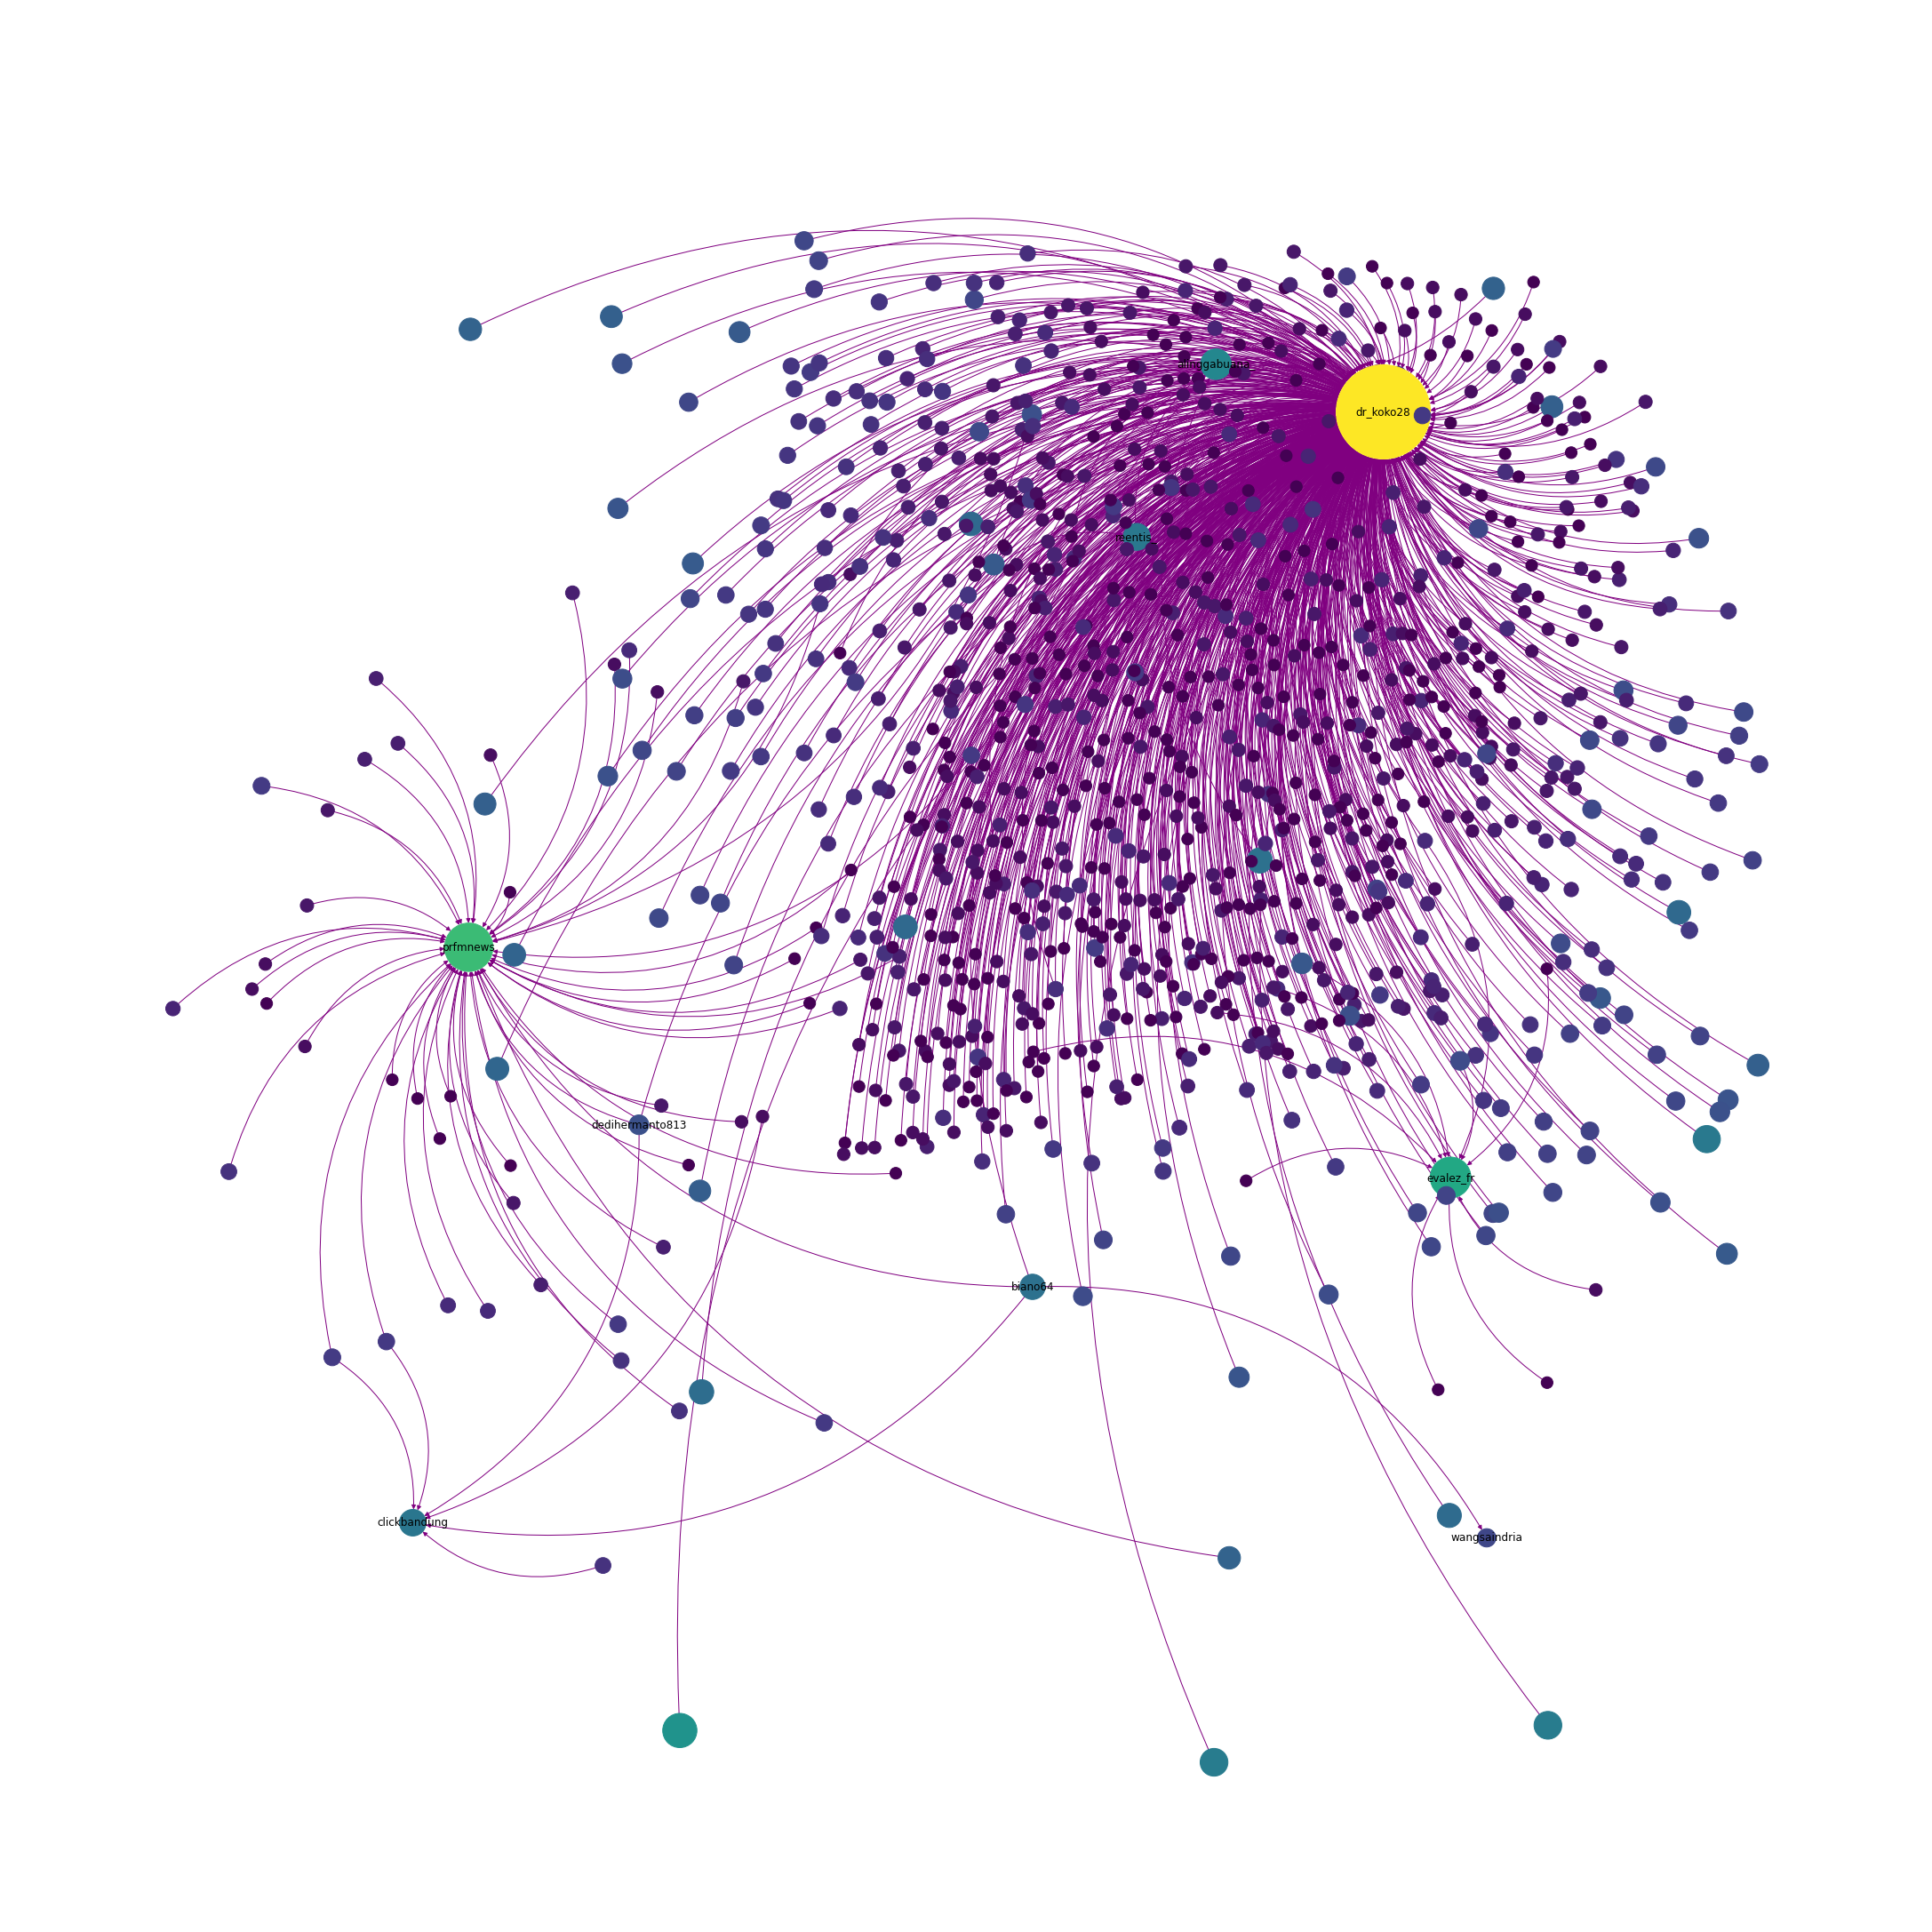

In [142]:
plt.figure(figsize=(30,30))
# pos = nx.spring_layout(G1)
pos = forceatlas2_layout(G1)
nx.draw(G1, with_labels=False, edge_color='purple', node_size=nodeSize, node_color=nodeColor ,node_shape = 'o' , pos=pos, connectionstyle='arc3, rad = -0.3')
nx.draw_networkx_labels(G1, pos ,labels=labels)
plt.show()

In [ ]:
#

In [ ]:
G2 = nx.DiGraph()
plt.figure(figsize=(15,15))

node = []
nodeSize = []
nodeColor = []

for key, value in af_nodes.items():
    G2.add_node(key)
    node.append(key)

minSize = 10
edgeWeight = []
for key, value in af_edges.items():
    if(value >= minSize ):
        G2.add_edge(key[1], key[0], weight = value)
        edgeWeight.append(math.log(value))

G2.remove_nodes_from(list(nx.isolates(G2)))
for key, value in af_nodes.items():
    if key in list(G2.nodes):
        nodeSize.append(math.sqrt(value * 100) * 20)
        nodeColor.append(1/value)

nx.draw(G2, with_labels=True ,edge_color='purple', width=edgeWeight, node_size=nodeSize, node_shape = 'o' ,node_color = nodeColor, pos=nx.random_layout(G2), connectionstyle='arc3, rad = -0.3')
plt.show()

In [ ]:
sorted_x = sorted(nx.closeness_centrality(G2).items(), key=lambda kv: kv[1], reverse=True)
# sorted_x = sorted(nx.betweenness_centrality(G2).items(), key=lambda kv: kv[1], reverse=True)
sorted_x